<a href="https://colab.research.google.com/github/cs-dan/Self-Projects/blob/main/HiraganaModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Before running code (first script), upload the datasets into colab, they can be found in the given link:
#https://colab.research.google.com/drive/14sFiBgKDV-fQUNV6ckPRyxZtm5Ohew4n?usp=sharing
#
#Upload HiraganaR.npz for the first script.
#Upload weightsHiragana.npy for the second script to see accuracy for best trained weights so far.

Streaming output truncated to the last 5000 lines.
Loss is:  0.047202332904373985  at  1397  iteration(s) at  わ .
Loss is:  0.05543193205228854  at  1398  iteration(s) at  い .
Loss is:  0.007014982297077998  at  1399  iteration(s) at  て .
Loss is:  0.3464870381010768  at  1400  iteration(s) at  も .
Loss is:  0.02970860597958113  at  1401  iteration(s) at  の .
Loss is:  0.010031505009001204  at  1402  iteration(s) at  れ .
Loss is:  0.05016932799289261  at  1403  iteration(s) at  じ .
Loss is:  0.0616396725985787  at  1404  iteration(s) at  げ .
Loss is:  0.0034676129926730394  at  1405  iteration(s) at  だ .
Loss is:  0.009071938387534761  at  1406  iteration(s) at  は .
Loss is:  0.059654667297376986  at  1407  iteration(s) at  も .
Loss is:  0.01328729211722464  at  1408  iteration(s) at  こ .
Loss is:  0.002502619557712562  at  1409  iteration(s) at  げ .
Loss is:  0.06919040957116238  at  1410  iteration(s) at  て .
Loss is:  0.00436572920908027  at  1411  iteration(s) at  わ .
Loss is:  0.0

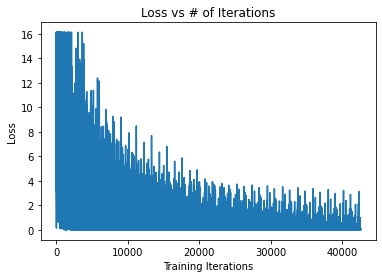

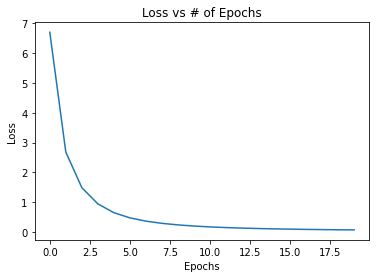

In [ ]:
####################################################################
######################### Hiragana Program #########################
####################################################################
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

################################################################################
######################### Convolution Neural Net Class #########################
#regarding weightMatrix, layerMatrix, derivativeMatrix
#defined as ""matrix[layer][(row,)-matrix] for layerMatrix/derivativeMatrix, where row = # of nodes 
#defined as ""matrix[layer][(row,col)-matrix] for weightMatrix/derivativeMatrix, where row = size of flattened sample, col = # of nodes


class cnn(object):
  def __init__(self, learning_rate=0.0005):
    self.c = learning_rate
    self.weightMatrix = [np.empty(shape=(0,0)),np.empty(shape=(0,0))]  #list holding weights from each time weight was called.
    self.layerMatrix = [np.empty(shape=(0,0)),np.empty(shape=(0,0)),np.empty(shape=(0,0))] #list holding node values from each dense layer 
    self.derivativeMatrix = [np.empty(shape=(0,0)),np.empty(shape=(0,0))] #list holding derivatives for each layer
    self.char = ['あ','い','う','え','お','か','が','き','ぎ','く','ぐ','け','げ','こ','ご','さ','ざ','し','じ','す','ず','せ','ぜ','そ','ぞ','た','だ','ち','ぢ','つ','づ','て','で','と','ど','な','に','ぬ','ね','の','は','ば','ぱ','ひ','び','ぴ','ふ','ぶ','ぷ','へ','べ','ぺ','ほ','ぼ','ぽ','ま','み','む','め','も','や','ゆ','よ','ら','り','る','れ','ろ','わ','を','ん',]
    self.correct = 0
    self.accuracyF = np.empty(shape=(0,), dtype=float)
    self.lossF = np.empty(shape=(0,), dtype=float)

  def conv1(self, input, kernel_size=(3,3), strides=(1,1), padding = 2):
    """ First convolutional layer """
    input = input
    kernel1 = np.array([[[0,-3,0],[-3,15,-3],[0,-3,0]]]) #sharpening filter
    kernel2 = np.array([[[-5,-15,-5],[0,0,0],[5,15,5]]]) #vertical filter
    kernel3 = np.array([[[-5,0,5],[-15,0,15],[-5,0,5]]]) #horizontal filter    
    filter = np.concatenate((kernel1, kernel2, kernel3))
    output = np.zeros(shape=(filter.shape[0], input.shape[0]-2, input.shape[1]-2))
    window = np.zeros(shape=(3,3))
    B = -1
    for i in range(filter.shape[0]): #per kernel
      for j in range(input.shape[0] - 2 ):  #rows
        for k in range(input.shape[1] - 2 ): #columns 
          window = input[j:j+3, k:k+3]   #select window 
          activation = self.ReLu( np.sum(np.tensordot(window, filter[i])) + B) #
          output[i,j,k] = activation #Y = B + X*K and activation  
    return output
  
  def conv2(self, input, kernel_size=(3,3), strides=(1,1), padding=2):
    """Second convolutional layer"""
    input = input
    kernel1 = np.array([[[0,-1,0],[-1,5,-1],[0,-1,0]]]) #vertical filter
    kernel2 = np.array([[[-1,-2,-1],[0,0,0],[1,2,1]]]) #vertical filter
    kernel3 = np.array([[[-1,0,1],[-2,0,2],[-1,0,1]]]) #horizontal filter
    filter = np.concatenate((kernel1, kernel2, kernel3))
    output = np.zeros(shape=(input.shape[0], input.shape[1]-2, input.shape[2]-2))
    window = np.zeros(shape=(3,3))
    B = -1
    for i in range(input.shape[0]):
      for j in range(input.shape[1] - 2 ):  #rows
        for k in range(input.shape[2] - 2 ): #columns 
          window = input[i, j:j+3, k:k+3]   #select window 
          activation = self.ReLu( np.sum(np.tensordot(window, filter[i])) + B) 
          output[i,j,k] = activation #Y = B + X*K and activation
    return output

  def conv3(self, input, kernel_size=(3,3), strides=(1,1), padding=2):
    """Third convolutional layer"""
    input = input
    kernel1 = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]]) #sharpening filter
    output = np.zeros(shape=(input.shape[0], input.shape[1]-2, input.shape[2]-2))
    window = np.zeros(shape=(3,3))
    B = -1
    for i in range(input.shape[0]): #per kernel
      for j in range(input.shape[1] - 2 ):  #rows
        for k in range(input.shape[2] - 2 ): #columns 
          window = input[i, j:j+3, k:k+3]   #select window 
          activation = self.ReLu( np.sum(np.tensordot(window, kernel1)) + B) #
          output[i,j,k] = activation #Y = B + X*K and activation
    return output

  def pooling(self, input, pool_size=(2,2), strides=(2,2)):
    """Pooling layer to extract max"""
    self.arr = input  #input set of convoluted images 
    output = np.zeros(shape=(input.shape[0], int(input.shape[1]/strides[0]), int(input.shape[2]/strides[1]))) #shape of output
    for i in range(self.arr.shape[0]): #per feature map
      for j in range(0, self.arr.shape[1], strides[0]): #rows
        for k in range(0, self.arr.shape[2], strides[1]): #columns
          if int(j/2) >= output.shape[1] or int(k/2) >= output.shape[2]: break
          window = self.arr[i, j:j+strides[0], k:k+strides[1]]   #select window    #mistake: you set self.arr to np.arr instead, generating random vals
          output[i,int(j/2),int(k/2)] = np.max(window)   #get max from window
    return output   #output pool layers

  def flatten(self, input):
    """reshape layer"""
    output = np.reshape(input, input.size)    #reshape all array elements into a 1d array
    return output #output flattened layers

  def denseSetup(self, input, layers, nodes, skip=False):
    """setting up fully connection section"""
    random = np.random.RandomState(1)
    self.layerMatrix[0] = np.zeros(shape=(input.size+1,))
    self.layerMatrix[1] = np.zeros(shape=(nodes[0],))
    self.layerMatrix[2] = np.zeros(shape=(nodes[1],))
    for i in range(layers):
      if skip == False:
        self.weightMatrix[i] = random.normal(loc=0.0, scale=0.1, size=(self.layerMatrix[i].shape[0], nodes[i])) #weights per node
      self.derivativeMatrix[i] = np.zeros(shape=(nodes[i],)) #layer derivatives 
  
  def denseNetwork(self, input): 
    """fully connected section, forward pass"""
    self.layerMatrix[0] = input  #input layer
    self.layerMatrix[0] = np.append(self.layerMatrix[0], 1)
    self.layerMatrix[0] = self.layerMatrix[0] / 10
    l=0
    for l in range(len(self.layerMatrix)-1):
      next = l + 1
      for i in range(self.layerMatrix[next].shape[0]):  #next layer num nodes
        if next == len(self.layerMatrix)-1: 
          self.layerMatrix[next][i] = np.dot(self.layerMatrix[l], self.weightMatrix[l][:,i])
        else: 
          self.layerMatrix[next][i] = self.ReLu(np.dot(self.layerMatrix[l], self.weightMatrix[l][:,i]))
    self.layerMatrix[2] = self.softMax(self.layerMatrix[len(self.layerMatrix)-1]) #output layer
    self.layerMatrix[2][np.abs(self.layerMatrix[2]) < 1e-7] = 1e-7 #array[np.abs(array) < eps] = 0
    self.biggest = np.argmax(self.layerMatrix[2])
    return self.layerMatrix[2]

  def denseBack(self, loss):
    """fully connected section, backpropagation"""
    derivative1 = np.zeros(shape=(self.layerMatrix[2].shape[0]))  #derivative array at output
    derivative2 = np.zeros(shape=(self.layerMatrix[1].shape[0]))  #derivative array at hidden

    #output layer to hidden layer 
    for i in range(self.layerMatrix[1].shape[0]):  #for layer below current (hidden)
      for j in range(self.layerMatrix[2].shape[0]):  #for current layer (output)
        derivative1[j] = -self.target[j] + self.layerMatrix[2][j]   #crossentropy loss - softmax derivative
        dLayer = self.layerMatrix[1][i]*derivative1[j]*self.c #- self.m*derivative1[j]  #activation*derivative*learning rate
        self.weightMatrix[1][i,j] -= dLayer

    #hidden layer to flatten layer 
    for i in range(self.layerMatrix[0].shape[0]):
      for j in range(self.layerMatrix[1].shape[0]):
        derivative2[j] = np.greater(self.layerMatrix[1][j], 0).astype(int)*np.dot(derivative1, self.weightMatrix[1][j])  #relu - past derivative derivative
        dLayer = self.layerMatrix[0][i]*derivative2[j]*self.c #- self.m*derivative2[j]
        self.weightMatrix[0][i,j] -= dLayer

  def ReLu(self, input):
    return max(0.0, input)   # if greater than 0, return num, if less than 0, return 0

  def Loss(self, output): 
    """categorical cross-entropy loss"""
    return -np.sum(self.target*np.log(output))   #loss = -sum(class*ln(output))

  def softMax(self, input):
    return np.exp(input)/np.sum(np.exp(input), axis=0)

  def encode(self, classes, target):
    """one hot encode"""
    target.fill(0) 
    target[classes] = 1
    return target

  def predictPreloaded(self, data, targets):
    """predict function for loading saved weights"""
    self.loadWeights()
    self.target = np.zeros((71,),dtype=int)
    for i in range(data.shape[0]):
      input = data[i]
      input = self.conv1(input=input)
      input = self.pooling(input=input)
      input = self.conv2(input=input)
      input = self.pooling(input=input)
      input = self.flatten(input=input)
      if i == 0: 
        self.denseSetup(input, layers=2,nodes=[12*12*2,48], skip=True)
      output = self.denseNetwork(input=input)
      self.target = self.encode(targets[i], self.target)
      if np.argmax(output) == self.target[i]:
        self.correct += 1
      print("predicted: ", np.argmax(output))
      print("actual: ", targets[i])
    print(self.accuracy.shape, data.shape)
    print("Predicition Accuracy Rate: ", 100*(self.correct/data.shape[0]))   #(self.accuracy.shape[0]/data.shape[0]), "%")
    self.correct = 0

  def predict(self, data, targets):
    """predict function for training"""
    for i in range(data.shape[0]):
      input = data[i]
      input = self.conv1(input=input)
      input = self.pooling(input=input)
      input = self.conv2(input=input)
      input = self.pooling(input=input)
      input = self.flatten(input=input)
      output = self.denseNetwork(input=input)
      self.target = self.encode(targets[i], self.target)
      if np.argmax(output) == targets[i]:
        self.correct += 1
      print("predicted: ", np.argmax(output))
      print("actual: ", targets[i])
    print("Prediction Accuracy Rate: ", 100*(self.accuracy.shape[0]/data.shape[0]), "%")
    self.accuracyF = np.append(self.accuracyF, 100*(self.correct/data.shape[0]))  #(self.accuracy.shape[0]/data.shape[0]))
    self.correct = 0 

  
  def fit(self, features, classes, epochs): 
    rest, features, restid, classes = train_test_split(images, classes, test_size=0.1875,  stratify=classes)
    """main training function"""
    self.target = np.zeros((71,),dtype=int)
    self.lossE = np.zeros(shape=(0,))
    error = 100
    epochLoss = 0
    print("Starting training...")
    for e in range(epochs):
      for i in range(features.shape[0]):
        if i > 50 and np.sum(self.lossF[i-50:i])/50 <= 1e-2:
          print("Early breaking condition reached. Acceptable loss range hit.")
          print("Loss was: ", error)
          self.saveWeights()
          return self
        ##################################
        ########## forward pass ##########
        input = features[i]
        input = self.conv1(input=input)
        input = self.pooling(input=input)
        input = self.conv2(input=input)
        input = self.pooling(input=input)
        input = self.conv3(input=input)
        input = self.flatten(input=input)
        if e == 0 and i == 0: 
          self.denseSetup(input, layers=2,nodes=[384,71])
        self.target = self.encode(classes[i], self.target)
        output = self.denseNetwork(input=input)
        ##########################
        ########## loss ##########
        error = self.Loss(output)
        self.lossF = np.append(self.lossF, error) #[i] = error
        epochLoss += error
        ###############################
        ########## back pass ##########
        self.denseBack(error)
        # if i % 100 == 0 and i > 0:    #every 100 iterations, test validation data
        #   self.predict(valid_data[0][int(i/10)-10:i], valid_data[1][int(i/10)-10:i])  #features, classes) #valid_data[0], valid_data[1])
        #   print("Loss is: ", error, " at ", i, " iterations.")
        print("Loss is: ", error, " at ", i, " iteration(s) at ", self.char[classes[i]], ".")
      self.lossE = np.append(self.lossE, epochLoss/features.shape[0]) #self.lossF.size)
      epochLoss = 0
      print("Loss at epoch = ", self.lossE[e])
      print("Epoch ", e+1, " completed.")
    print("Finished!")
    self.saveWeights()
    return self
  def saveWeights(self):
    w = np.asarray(self.weightMatrix, dtype=object)
    with open('weightsHiragana.npy', 'wb') as f:
      np.save(f, w)
  
  def loadWeights(self):
    with open('weightsHiragana.npy', 'rb') as f:
      temp = np.load(f, allow_pickle=True)
    for i in range(len(self.weightMatrix)):
      self.weightMatrix[i] = temp[i]
    print(len(self.weightMatrix))
    assert len(self.weightMatrix) == 2

############################################################################
############################## Data Init ##############################

loaded = np.load('hiraganaR.npz')
images = loaded['a']
classes = loaded['b']
print(images.shape, classes.shape)

########################################################################
############################## Model Init ##############################

model = cnn().fit(images, classes, 20 )

##################################################################################
############################## Metric Visualization ##############################

plt.plot(model.lossF) 
plt.ylabel('Loss')
plt.xlabel('Training Iterations')
plt.title('Loss vs # of Iterations')
plt.show()

plt.plot(model.lossE)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Loss vs # of Epochs')
plt.show()



In [ ]:
#session for predictions
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

################################################################################
######################### Convolution Neural Net Class #########################
#regarding weightMatrix, layerMatrix, derivativeMatrix
#defined as ""matrix[layer][(row,)-matrix] for layerMatrix/derivativeMatrix, where row = # of nodes 
#defined as ""matrix[layer][(row,col)-matrix] for weightMatrix/derivativeMatrix, where row = size of flattened sample, col = # of nodes


class cnn(object):
  def __init__(self, learning_rate=0.0005):
    self.c = learning_rate
    self.weightMatrix = [np.empty(shape=(0,0)),np.empty(shape=(0,0))]  #list holding weights from each time weight was called.
    self.layerMatrix = [np.empty(shape=(0,0)),np.empty(shape=(0,0)),np.empty(shape=(0,0))] #list holding node values from each dense layer 
    self.derivativeMatrix = [np.empty(shape=(0,0)),np.empty(shape=(0,0))] #list holding derivatives for each layer
    self.char = ['あ','い','う','え','お','か','が','き','ぎ','く','ぐ','け','げ','こ','ご','さ','ざ','し','じ','す','ず','せ','ぜ','そ','ぞ','た','だ','ち','ぢ','つ','づ','て','で','と','ど','な','に','ぬ','ね','の','は','ば','ぱ','ひ','び','ぴ','ふ','ぶ','ぷ','へ','べ','ぺ','ほ','ぼ','ぽ','ま','み','む','め','も','や','ゆ','よ','ら','り','る','れ','ろ','わ','を','ん',]
    self.correct = 0
    self.accuracyF = np.empty(shape=(0,), dtype=float)
    self.lossF = np.empty(shape=(0,), dtype=float)

  def conv1(self, input, kernel_size=(3,3), strides=(1,1), padding = 2):
    input = input
    kernel1 = np.array([[[0,-3,0],[-3,15,-3],[0,-3,0]]]) #sharpening filter
    kernel2 = np.array([[[-5,-15,-5],[0,0,0],[5,15,5]]]) #vertical filter
    kernel3 = np.array([[[-5,0,5],[-15,0,15],[-5,0,5]]]) #horizontal filter    
    filter = np.concatenate((kernel1, kernel2, kernel3))
    output = np.zeros(shape=(filter.shape[0], input.shape[0]-2, input.shape[1]-2))
    window = np.zeros(shape=(3,3))
    B = -1
    for i in range(filter.shape[0]): #per kernel
      for j in range(input.shape[0] - 2 ):  #rows
        for k in range(input.shape[1] - 2 ): #columns 
          window = input[j:j+3, k:k+3]   #select window 
          activation = self.ReLu( np.sum(np.tensordot(window, filter[i])) + B) #
          output[i,j,k] = activation #Y = B + X*K and activation 
    return output
  
  def conv2(self, input, kernel_size=(3,3), strides=(1,1), padding=2):
    input = input
    kernel1 = np.array([[[0,-1,0],[-1,5,-1],[0,-1,0]]]) #vertical filter
    kernel2 = np.array([[[-1,-2,-1],[0,0,0],[1,2,1]]]) #vertical filter
    kernel3 = np.array([[[-1,0,1],[-2,0,2],[-1,0,1]]]) #horizontal filter
    filter = np.concatenate((kernel1, kernel2, kernel3))
    output = np.zeros(shape=(input.shape[0], input.shape[1]-2, input.shape[2]-2))
    window = np.zeros(shape=(3,3))
    B = -1
    for i in range(input.shape[0]):
      for j in range(input.shape[1] - 2 ):  #rows
        for k in range(input.shape[2] - 2 ): #columns 
          window = input[i, j:j+3, k:k+3]   #select window 
          activation = self.ReLu( np.sum(np.tensordot(window, filter[i])) + B) 
          output[i,j,k] = activation #Y = B + X*K and activation
    return output

  def conv3(self, input, kernel_size=(3,3), strides=(1,1), padding=2):
    input = input
    kernel1 = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]]) #sharpening filter
    output = np.zeros(shape=(input.shape[0], input.shape[1]-2, input.shape[2]-2))
    window = np.zeros(shape=(3,3))
    B = -1
    for i in range(input.shape[0]): #per kernel
      for j in range(input.shape[1] - 2 ):  #rows
        for k in range(input.shape[2] - 2 ): #columns 
          window = input[i, j:j+3, k:k+3]   #select window 
          activation = self.ReLu( np.sum(np.tensordot(window, kernel1)) + B) #
          output[i,j,k] = activation #Y = B + X*K and activation
    return output

  def pooling(self, input, pool_size=(2,2), strides=(2,2)):
    self.arr = input  #input set of convoluted images 
    output = np.zeros(shape=(input.shape[0], int(input.shape[1]/strides[0]), int(input.shape[2]/strides[1]))) #shape of output
    for i in range(self.arr.shape[0]): #per feature map
      for j in range(0, self.arr.shape[1], strides[0]): #rows
        for k in range(0, self.arr.shape[2], strides[1]): #columns
          if int(j/2) >= output.shape[1] or int(k/2) >= output.shape[2]: break
          window = self.arr[i, j:j+strides[0], k:k+strides[1]]   #select window    #mistake: you set self.arr to np.arr instead, generating random vals
          output[i,int(j/2),int(k/2)] = np.max(window)   #get max from window
    return output   #output pool layers

  def flatten(self, input):
    output = np.reshape(input, input.size)    #reshape all array elements into a 1d array
    return output #output flattened layers

  def denseSetup(self, input, layers, nodes, skip=False):
    random = np.random.RandomState(1)
    self.layerMatrix[0] = np.zeros(shape=(input.size+1,))
    self.layerMatrix[1] = np.zeros(shape=(nodes[0],))
    self.layerMatrix[2] = np.zeros(shape=(nodes[1],))
    for i in range(layers):
      if skip == False:
        self.weightMatrix[i] = random.normal(loc=0.0, scale=0.1, size=(self.layerMatrix[i].shape[0], nodes[i])) #weights per node
      self.derivativeMatrix[i] = np.zeros(shape=(nodes[i],)) #layer derivatives 
  
  def denseNetwork(self, input): #forward, backward, on all samples of given epoch
    self.layerMatrix[0] = input  #input layer
    self.layerMatrix[0] = np.append(self.layerMatrix[0], 1)
    self.layerMatrix[0] = self.layerMatrix[0] / 10
    l=0
    for l in range(len(self.layerMatrix)-1):
      next = l + 1
      for i in range(self.layerMatrix[next].shape[0]):  #next layer num nodes
        if next == len(self.layerMatrix)-1: 
          self.layerMatrix[next][i] = np.dot(self.layerMatrix[l], self.weightMatrix[l][:,i])
        else: 
          self.layerMatrix[next][i] = self.ReLu(np.dot(self.layerMatrix[l], self.weightMatrix[l][:,i]))
    self.layerMatrix[2] = self.softMax(self.layerMatrix[len(self.layerMatrix)-1]) #output layer
    self.layerMatrix[2][np.abs(self.layerMatrix[2]) < 1e-7] = 1e-7 #array[np.abs(array) < eps] = 0
    self.biggest = np.argmax(self.layerMatrix[2])
    return self.layerMatrix[2]

  def denseBack(self, loss):
    derivative1 = np.zeros(shape=(self.layerMatrix[2].shape[0]))  #derivative array at output
    derivative2 = np.zeros(shape=(self.layerMatrix[1].shape[0]))  #derivative array at hidden

    #output layer to hidden layer 
    for i in range(self.layerMatrix[1].shape[0]):  #for layer below current (hidden)
      for j in range(self.layerMatrix[2].shape[0]):  #for current layer (output)
        derivative1[j] = -self.target[j] + self.layerMatrix[2][j]   #crossentropy loss - softmax derivative
        dLayer = self.layerMatrix[1][i]*derivative1[j]*self.c #- self.m*derivative1[j]  #activation*derivative*learning rate
        self.weightMatrix[1][i,j] -= dLayer

    #hidden layer to flatten layer 
    for i in range(self.layerMatrix[0].shape[0]):
      for j in range(self.layerMatrix[1].shape[0]):
        derivative2[j] = np.greater(self.layerMatrix[1][j], 0).astype(int)*np.dot(derivative1, self.weightMatrix[1][j])  #relu - past derivative derivative
        dLayer = self.layerMatrix[0][i]*derivative2[j]*self.c #- self.m*derivative2[j]
        self.weightMatrix[0][i,j] -= dLayer

  def ReLu(self, input):
    return max(0.0, input)   #hinge activation function, return value if greater than 0.0, otherwise return 0.0

  def Loss(self, output):    #categorical cross-entropy loss
    return -np.sum(self.target*np.log(output))   #loss = -sum(class*ln(output))

  def softMax(self, input):
    return np.exp(input)/np.sum(np.exp(input), axis=0)

  def encode(self, classes, target):
    target.fill(0) 
    target[classes] = 1
    return target

  def predictPreloaded(self, data, targets):
    self.loadWeights()
    self.target = np.zeros((71,),dtype=int)
    for i in range(data.shape[0]):
      input = data[i]
      input = self.conv1(input=input)
      input = self.pooling(input=input)
      input = self.conv2(input=input)
      input = self.pooling(input=input)
      input = self.conv3(input=input)
      input = self.flatten(input=input)
      if i == 0: 
        self.denseSetup(input, layers=2,nodes=[384,71], skip=True)
      output = self.denseNetwork(input=input)
      self.target = self.encode(targets[i], self.target)
      if np.argmax(output) == targets[i]:
        self.correct += 1
      print("predicted: ", self.char[np.argmax(output)], ", actual: ", self.char[targets[i]])
    print("Predicition Accuracy Rate: ", 100*(self.correct/data.shape[0]))   #(self.accuracy.shape[0]/data.shape[0]), "%")
    self.correct = 0

  def predict(self, data, targets):
    for i in range(data.shape[0]):
      input = data[i]
      input = self.conv1(input=input)
      input = self.pooling(input=input)
      input = self.conv2(input=input)
      input = self.pooling(input=input)
      input = self.flatten(input=input)
      output = self.denseNetwork(input=input)
      if np.argmax(output) == targets[i]:
        self.correct += 1
      print("predicted: ", np.argmax(output))
      print("actual: ", targets[i])
    print("Prediction Accuracy Rate: ", 100*(self.accuracy.shape[0]/data.shape[0]), "%")
    self.accuracyF = np.append(self.accuracyF, 100*(self.correct/data.shape[0]))  #(self.accuracy.shape[0]/data.shape[0]))
    self.correct = 0 

  
  def fit(self, features, classes, epochs): #, valid_data):
    rest, features, restid, classes = train_test_split(images, classes, test_size=0.1875,  stratify=classes)
    """main training function"""
    self.target = np.zeros((71,),dtype=int)
    self.lossE = np.zeros(shape=(0,))
    error = 100
    epochLoss = 0
    print("Starting training...")
    for e in range(epochs):
      for i in range(features.shape[0]):
        if i > 50 and np.sum(self.lossF[i-50:i])/50 <= 1e-2:
          print("Early breaking condition reached. Acceptable loss range hit.")
          print("Loss was: ", error)
          self.saveWeights()
          return self
        ##################################
        ########## forward pass ##########
        input = features[i]
        input = self.conv1(input=input)
        input = self.pooling(input=input)
        input = self.conv2(input=input)
        input = self.pooling(input=input)
        input = self.conv3(input=input)
        input = self.flatten(input=input)
        if e == 0 and i == 0: 
          self.denseSetup(input, layers=2,nodes=[384,71])
        self.target = self.encode(classes[i], self.target)
        output = self.denseNetwork(input=input)
        ##########################
        ########## loss ##########
        error = self.Loss(output)
        self.lossF = np.append(self.lossF, error) #[i] = error
        epochLoss += error
        ###############################
        ########## back pass ##########
        self.denseBack(error)
        # if i % 100 == 0 and i > 0:    #every 100 iterations, test validation data
        #   self.predict(valid_data[0][int(i/10)-10:i], valid_data[1][int(i/10)-10:i])  #features, classes) #valid_data[0], valid_data[1])
        #   print("Loss is: ", error, " at ", i, " iterations.")
        print("Loss is: ", error, " at ", i, " iteration(s) at ", self.char[classes[i]], ".")
      self.lossE = np.append(self.lossE, epochLoss/features.shape[0]) #self.lossF.size)
      epochLoss = 0
      print("Loss at epoch = ", self.lossE[e])
      print("Epoch ", e+1, " completed.")
    print("Finished!")
    self.saveWeights()
    return self
  def saveWeights(self):
    w = np.asarray(self.weightMatrix, dtype=object)
    with open('weightsHiragana.npy', 'wb') as f:
      np.save(f, w)
  
  def loadWeights(self):
    with open('weightsHiragana.npy', 'rb') as f:
      temp = np.load(f, allow_pickle=True)
    for i in range(len(self.weightMatrix)):
      self.weightMatrix[i] = temp[i]
    assert len(self.weightMatrix) == 2

############################################################################
############################## Data Init ##############################

loaded = np.load('hiraganaR.npz')
images = loaded['a']
classes = loaded['b']
rest, features, restid, classes = train_test_split(images, classes, test_size=0.0126,  stratify=classes)

########################################################################
############################## Model Init ##############################

model = cnn().predictPreloaded(features, classes)



(11360, 48, 48) (11360,)
2
predicted:  ち , actual:  ち
predicted:  ぴ , actual:  ぴ
predicted:  ぼ , actual:  ぽ
predicted:  ぽ , actual:  ぽ
predicted:  し , actual:  し
predicted:  ぶ , actual:  ぷ
predicted:  ぐ , actual:  ぐ
predicted:  ぽ , actual:  ぼ
predicted:  こ , actual:  と
predicted:  そ , actual:  そ
predicted:  せ , actual:  せ
predicted:  ぢ , actual:  ぢ
predicted:  が , actual:  が
predicted:  ぶ , actual:  ぶ
predicted:  で , actual:  で
predicted:  を , actual:  き
predicted:  か , actual:  か
predicted:  ぱ , actual:  ぱ
predicted:  け , actual:  せ
predicted:  げ , actual:  げ
predicted:  に , actual:  に
predicted:  ぱ , actual:  ば
predicted:  の , actual:  の
predicted:  ろ , actual:  ろ
predicted:  す , actual:  ず
predicted:  れ , actual:  れ
predicted:  ゆ , actual:  ゆ
predicted:  ほ , actual:  ぺ
predicted:  ぬ , actual:  ぬ
predicted:  さ , actual:  さ
predicted:  て , actual:  で
predicted:  お , actual:  お
predicted:  す , actual:  す
predicted:  む , actual:  む
predicted:  こ , actual:  ご
predicted:  ぷ , actual:  ぴ
p